## MNIST on in Keras with Tensorboard

This sample trains an "MNIST" handwritten digit 
recognition model on a GPU or TPU backend using a Keras
model. Data are handled using the tf.data.Datset API. This is
a very simple sample provided for educational purposes. Do
not expect outstanding TPU performance on a dataset as
small as MNIST.

### Parameters

In [1]:
BATCH_SIZE = 32
LEARNING_RATE = 0.02
LOG_BUCKET="" # local Tensorboard logs if empty, otherwise a gs:// path

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [2]:
import os, re, math, json, shutil, pprint, time
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.python.platform import tf_logging
from tensorflow.python.keras import backend as K
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.0.0-alpha0


## TPU detection

In [3]:
tpu = None
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.tpu.experimental.initialize_tpu_system(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
except ValueError:
  print("Running on CPU or GPU")
    
if tpu:
  strategy = tf.distribute.experimental.TPUStrategy(tpu, steps_per_run=100)
else:
  strategy = tf.distribute.get_strategy() # the default strategy works on CPU and single GPU

# adjust batch size and learning rate for distributed computing
global_batch_size = BATCH_SIZE
learning_rate = LEARNING_RATE
if tpu:
    global_batch_size = BATCH_SIZE * 8  # A single TPU has 8 cores
    learning_rate = LEARNING_RATE * 8  # Scale the learning rate along with the batch size 

Running on CPU or GPU


In [4]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  unbatched_train_ds = training_dataset.apply(tf.data.experimental.unbatch())
  
  if tf.executing_eagerly():
      # This is the TF 2.0 "eager execution" way of iterating through a tf.data.Dataset
      for v_images, v_labels in validation_dataset:
        break

      for t_images, t_labels in unbatched_train_ds.batch(N):
        break

      validation_digits = v_images.numpy()
      validation_labels = v_labels.numpy()
      training_digits   = t_images.numpy()
      training_labels   = t_labels.numpy()
  else:
    # This is the legacy TF 1.x way of iterating through a tf.data.Dataset
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = unbatched_train_ds.batch(N).make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)
    
# utility to display training and validation curves
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.grid(linewidth=1, color='white')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

### Colab-only auth for this notebook and the TPU

In [5]:
#IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
#if IS_COLAB_BACKEND:
#  from google.colab import auth
#  auth.authenticate_user() # Authenticates the backend and also the TPU using your credentials so that they can access your private GCS buckets

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [6]:
def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    #dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, global_batch_size)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, global_batch_size)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

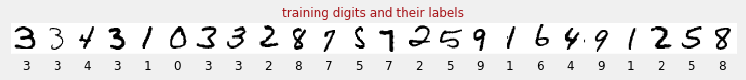

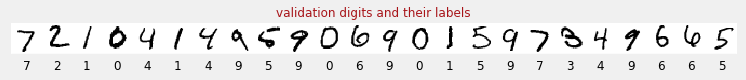

In [7]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model: 3 convolutional layers, 2 dense layers
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [8]:
# This model trains to 99.4%— sometimes 99.5%— accuracy in 10 epochs (with a batch size of 32)

def make_model():
    model = tf.keras.Sequential(
      [
        tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),

        tf.keras.layers.Conv2D(filters=6, kernel_size=3, padding='same', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=12, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=24, kernel_size=6, padding='same', use_bias=False, strides=2),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(200, use_bias=False, name='dense1'),
        tf.keras.layers.BatchNormalization(scale=False, center=True, name='bn1'),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.Dropout(0.5), # Dropout on dense layer only

        tf.keras.layers.Dense(10, activation='softmax')
      ])

    model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
with strategy.scope(): # the new way of handling distribution strategies in Tensorflow 1.14+
    model = make_model()

# print model layers
model.summary()
                        
# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learning_rate * math.pow(0.5, 1+epoch) + learning_rate/200, verbose=True)
log_dir=os.path.join(LOG_BUCKET, 'logs/'+str(time.time()))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq=50*global_batch_size)
print(log_dir)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         54        
_________________________________________________________________
batch_normalization_v2 (Batc (None, 28, 28, 6)         18        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 12)        2592      
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 14, 14, 12)        36        
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 12)        0

### Train and validate the model

In [9]:
EPOCHS = 10
steps_per_epoch = 60000//global_batch_size  # 60,000 items in this dataset
print("Step (batches) per epoch: ", steps_per_epoch)

# Counting steps and batches on TPU: the tpu.keras_to_tpu_model API regards the batch size of the input dataset
# as the per-core batch size. The effective batch size is 8x more because Cloud TPUs have 8 cores. It increments
# the step by +8 everytime a global batch (8 per-core batches) is processed. Therefore batch size and steps_per_epoch
# settings can stay as they are for TPU training. The training will just go faster.
# Warning: this might change in the final version of the Keras/TPU API.
  
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                            validation_data=validation_dataset, validation_steps=1, callbacks=[lr_decay, tb_callback])

Step (batches) per epoch:  1875

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0101.
Epoch 1/10
   1/1875 [..............................] - ETA: 1:56:01 - loss: 3.5008 - accuracy: 0.0938

W0612 20:10:53.047358 139807690958592 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.107169). Check your callbacks.


1875/1875 [==============================] - 27s 14ms/step - loss: 0.1651 - accuracy: 0.9512 - val_loss: 0.0794 - val_accuracy: 0.9773

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0051.
Epoch 2/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0691 - accuracy: 0.9798 - val_loss: 0.0327 - val_accuracy: 0.9889

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0026.
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0446 - accuracy: 0.9864 - val_loss: 0.0310 - val_accuracy: 0.9901

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00135.
Epoch 4/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0304 - accuracy: 0.9908 - val_loss: 0.0181 - val_accuracy: 0.9939

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0007250000000000001.
Epoch 5/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0174 - val_ac

### Visualize training and validation curves

dict_keys(['loss', 'val_loss', 'accuracy', 'val_accuracy', 'lr'])


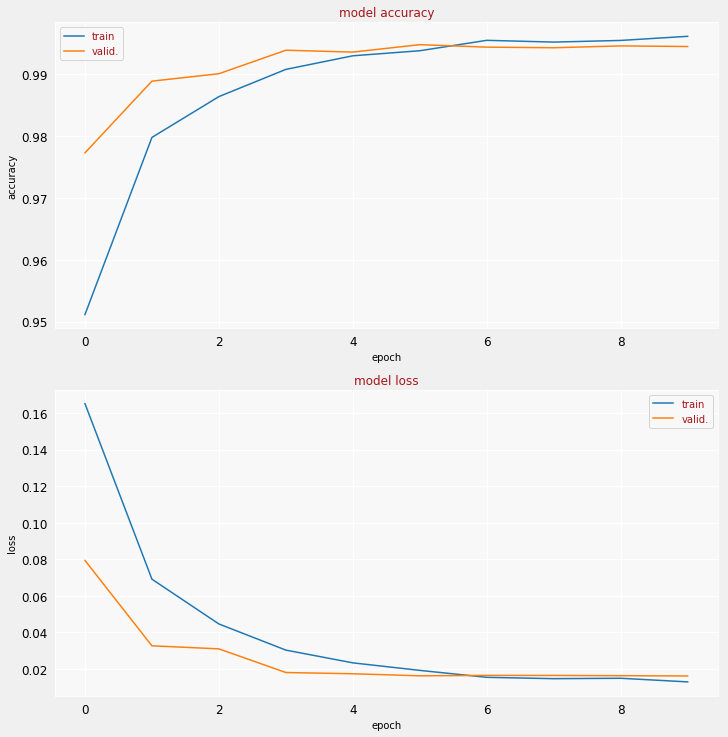

In [10]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

### Visualize predictions

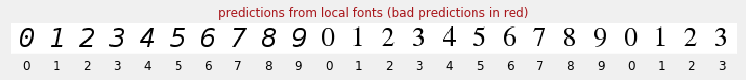

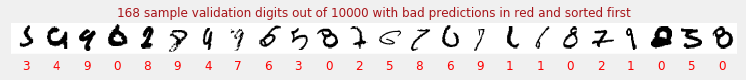

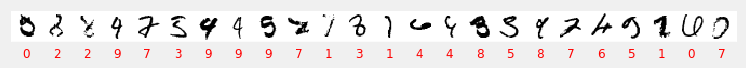

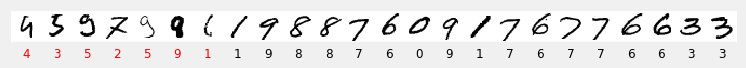

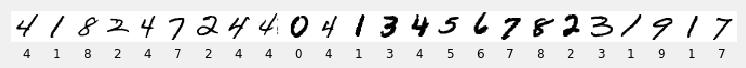

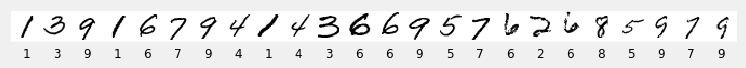

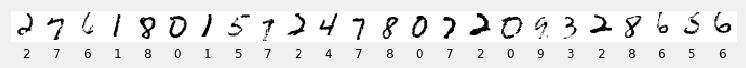

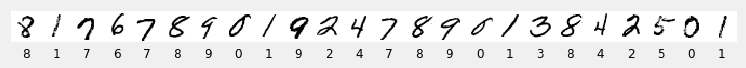

In [11]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## Deploy the trained model to ML Engine

Push your trained model to production on ML Engine for a serverless, autoscaled, REST API experience.

You will need a GCS bucket and a GCP project for this.
Models deployed on ML Engine autoscale to zero if not used. There will be no ML Engine charges after you are done testing.
Google Cloud Storage incurs charges. Empty the bucket after deployment if you want to avoid these. Once the model is deployed, the bucket is not useful anymore.

### Cloud Configuration

In [19]:
PROJECT = "" #@param {type:"string"}
BUCKET = "gs://"  #@param {type:"string", default:"jddj"}
NEW_MODEL = True #@param {type:"boolean"}
MODEL_NAME = "mnist" #@param {type:"string"}
MODEL_VERSION = "v0" #@param {type:"string"}

assert PROJECT, 'For this part, you need a GCP project. Head to http://console.cloud.google.com/ and create one.'
assert re.search(r'gs://.+', BUCKET), 'For this part, you need a GCS bucket. Head to http://console.cloud.google.com/storage and create one.'

### Export the model for serving from ML Engine

In [20]:
class ServingInput(tf.keras.layers.Layer):
  # the important detail in this boilerplate code is "trainable=False"
  def __init__(self, name, dtype, batch_input_shape=None):
    super(ServingInput, self).__init__(trainable=False, name=name, dtype=dtype, batch_input_shape=batch_input_shape)
  def get_config(self):
    return {'batch_input_shape': self._batch_input_shape, 'dtype': self.dtype, 'name': self.name }

  def call(self, inputs):
    # When the deployed model is called through its REST API,
    # the JSON payload is parsed automatically, transformed into
    # a tensor and passed to this input layer. You can perform
    # additional transformations, such as decoding JPEGs for example,
    # before sending the data to your model. However, you can only
    # use tf.xxxx operations.
    return inputs

# little wrinkle: must copy the model from TPU to CPU manually. This is a temporary workaround.
tf_logging.set_verbosity(tf_logging.INFO)
restored_model = make_model()
restored_model.set_weights(model.get_weights()) # this copied the weights from TPU, does nothing on GPU
tf_logging.set_verbosity(tf_logging.WARN)

# add the serving input layer
serving_model = tf.keras.Sequential()
serving_model.add(ServingInput('serving', tf.float32, (None, 28*28)))
serving_model.add(restored_model)
export_path = os.path.join(BUCKET, 'keras_export')
tf.saved_model.save(serving_model, export_path)  # export he model to your bucket
#export_path = export_path.decode('utf-8')
print("Model exported to: ", export_path)

Model exported to:  gs://ml1-demo-martin/mnistexport4/keras_export


### Deploy the model
This uses the command-line interface. You can do the same thing through the ML Engine UI at https://console.cloud.google.com/mlengine/models


In [21]:
# Create the model
if NEW_MODEL:
  !gcloud ai-platform models create {MODEL_NAME} --project={PROJECT} --regions=us-central1

Created ml engine model [projects/cloudml-demo-martin/models/colabmnist4].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [22]:
# Create a version of this model (you can add --async at the end of the line to make this call non blocking)
# Additional config flags are available: https://cloud.google.com/ml-engine/reference/rest/v1/projects.models.versions
# You can also deploy a model that is stored locally by providing a --staging-bucket=... parameter
!echo "Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/{MODEL_NAME}"
!gcloud ai-platform versions create {MODEL_VERSION} --model={MODEL_NAME} --origin={export_path} --project={PROJECT} --runtime-version=1.13 --python-version=3.5

Deployment takes a couple of minutes. You can watch your deployment here: https://console.cloud.google.com/mlengine/models/colabmnist4
Creating version (this might take a few minutes)......done.


### Test the deployed model
Your model is now available as a REST API. Let us try to call it. The cells below use the "gcloud ml-engine"
command line tool but any tool that can send a JSON payload to a REST endpoint will work.

In [23]:
# prepare digits to send to online prediction endpoint
digits = np.concatenate((font_digits, validation_digits[:100-N]))
labels = np.concatenate((font_labels, validation_labels[:100-N]))
with open("digits.json", "w") as f:
  for digit in digits:
    # the format for ML Engine online predictions is: one JSON object per line
    data = json.dumps({"serving_input": digit.tolist()})  # "serving_input" because the ServingInput layer was named "serving". Keras appends "_input"
    f.write(data+'\n')

['SEQUENTIAL_9', '[0.9999269247055054, 5.975887840126148e-11, 9.934588707238845e-10, 1.6049546136542858e-09, 1.4330276965068833e-09, 4.059224512076298e-09, 2.278062538607628e-06, 5.770196126464455e-11, 8.568408702558372e-06, 6.2202314438764e-05]', '[1.9415116980781022e-07, 0.9971803426742554, 0.002414541319012642, 1.8119354763257434e-06, 1.2241091553732986e-06, 1.560703282166287e-07, 4.329463010321888e-08, 0.00040127255488187075, 3.383921054478378e-08, 4.658683963043586e-07]', '[4.6243442408666624e-10, 5.549506340574162e-11, 1.0, 7.988082195709012e-09, 2.2456397737169714e-15, 3.3942705417178143e-13, 9.901922218367304e-14, 2.445557090169359e-09, 3.385686042634006e-08, 3.3901184810780638e-12]', '[4.7875992856575775e-14, 1.4186982144615e-10, 4.7039337702781125e-11, 1.0, 6.003022023562529e-15, 3.948006011000871e-08, 8.946246580660857e-16, 3.9476387436732097e-11, 1.0815817859388677e-11, 4.59377114125914e-09]', '[8.516845007022766e-09, 7.514559285937139e-08, 3.812922955148679e-07, 6.33424389

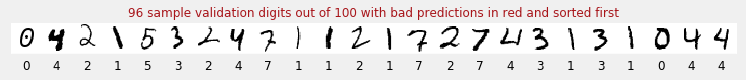

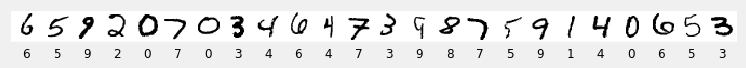

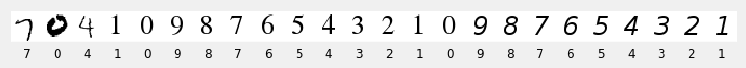

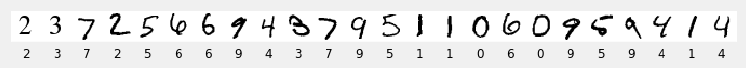

In [25]:
# Request online predictions from deployed model (REST API) using the "gcloud ai-platform" command line.
predictions = !gcloud ai-platform predict --model={MODEL_NAME} --json-instances digits.json --project={PROJECT} --version {MODEL_VERSION}
print(predictions)

probabilities = np.stack([json.loads(p) for p in predictions[1:]]) # first line is the name of the input layer: drop it, parse the rest
predictions = np.argmax(probabilities, axis=1)
display_top_unrecognized(digits, predictions, labels, N, 100//N)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
